# Pruning Results

In [3]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
ENTITY = "hp-learning-rules"

def fetch_project_data(project_name):
    """Fetch all runs from a wandb project"""
    api = wandb.Api()
    runs = api.runs(f"{ENTITY}/{project_name}")
    
    data = []
    for run in runs:
        row = {'run_id': run.id, 'run_name': run.name, 'state': run.state}
        
        # Add all config items
        for key, value in run.config.items():
            row[f'config_{key}'] = value
        
        # Add all summary metrics
        for key, value in run.summary._json_dict.items():
            if not key.startswith('_'):
                row[key] = value
        
        data.append(row)
    
    return pd.DataFrame(data)

In [25]:
def clean_data(df, project_type):
    
    if project_type == 'mnist':
        df['dataset'] = df['config_data'].apply(lambda x: 
            'MNIST' if 'mnist_datamodule.MNISTDataModule' in str(x) else
            'FashionMNIST' if 'mnist_datamodule.FashionMNISTDataModule' in str(x) else 
            'SelectiveCopying' if 'selectivecopying_datamodule.SelectiveCopyingDataModule' in str(x) else
            'Unknown'
        )
        
    else:  
        df['dataset'] = 'SelectiveCopying'
        

    df['optimizer'] = df['config_model'].apply(lambda x: 
        x.get('optimizer', {}).get('update_alg', 'unknown') if isinstance(x, dict) else 'unknown'
    )
    
    return df

In [23]:
mnist_df = fetch_project_data("prune-tests-grid")
selective_df = fetch_project_data("prune-tests-selcopy-grid")

mnist_clean = clean_data(mnist_df, 'mnist')
selective_clean = clean_data(selective_df, 'selective')

In [28]:
def print_summary(mnist_df, selective_df):

    if len(mnist_df) > 0:
        print("MNIST/Fashion-MNIST Results:")
        if 'test/acc' in mnist_df.columns:
            summary = mnist_df.groupby(['dataset', 'optimizer'])['test/acc'].agg(['mean', 'std', 'count'])
            print(summary.round(4))
    
    if len(selective_df) > 0:
        print("Selective Copying Results:")
        if 'test/acc' in selective_df.columns:
            summary = selective_df.groupby('optimizer')['test/acc'].agg(['mean', 'std', 'count'])
            print(summary.round(4))

print_summary(mnist_clean, selective_clean)

MNIST/Fashion-MNIST Results:
                          mean     std  count
dataset      optimizer                       
FashionMNIST gd         0.8880  0.0009      3
             md         0.8900  0.0024      3
MNIST        gd         0.9785  0.0012      3
             md         0.9784  0.0002      3
Selective Copying Results:
             mean     std  count
optimizer                       
gd         0.2421  0.0023      3
md         0.8109  0.1037      3


In [29]:
def plot_comparison(mnist_df, selective_df):
    """Create simple comparison plots"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot 1: MNIST/Fashion test accuracy
    if len(mnist_df) > 0 and 'test/acc' in mnist_df.columns:
        sns.boxplot(data=mnist_df, x='dataset', y='test/acc', hue='optimizer', ax=axes[0,0])
        axes[0,0].set_title('Test Accuracy: MNIST vs Fashion-MNIST')
        axes[0,0].set_ylabel('Test Accuracy')
    else:
        axes[0,0].text(0.5, 0.5, 'No MNIST test/acc data', ha='center', va='center')
    
    # Plot 2: Selective Copying test accuracy
    if len(selective_df) > 0 and 'test/acc' in selective_df.columns:
        sns.boxplot(data=selective_df, x='optimizer', y='test/acc', ax=axes[0,1])
        axes[0,1].set_title('Test Accuracy: Selective Copying')
        axes[0,1].set_ylabel('Test Accuracy')
    else:
        axes[0,1].text(0.5, 0.5, 'No Selective test/acc data', ha='center', va='center')
    
    # Plot 3: MNIST/Fashion validation accuracy
    if len(mnist_df) > 0 and 'val/acc_best' in mnist_df.columns:
        sns.boxplot(data=mnist_df, x='dataset', y='val/acc_best', hue='optimizer', ax=axes[0,2])
        axes[0,2].set_title('Best Val Accuracy: MNIST vs Fashion-MNIST')
        axes[0,2].set_ylabel('Best Val Accuracy')
    else:
        axes[0,2].text(0.5, 0.5, 'No MNIST val/acc_best data', ha='center', va='center')
    
    # Plot 4: MNIST/Fashion train accuracy
    if len(mnist_df) > 0 and 'train/acc' in mnist_df.columns:
        sns.boxplot(data=mnist_df, x='dataset', y='train/acc', hue='optimizer', ax=axes[1,0])
        axes[1,0].set_title('Train Accuracy: MNIST vs Fashion-MNIST')
        axes[1,0].set_ylabel('Train Accuracy')
    else:
        axes[1,0].text(0.5, 0.5, 'No MNIST train/acc data', ha='center', va='center')
    
    # Plot 5: Selective Copying validation accuracy
    if len(selective_df) > 0 and 'val/acc_best' in selective_df.columns:
        sns.boxplot(data=selective_df, x='optimizer', y='val/acc_best', ax=axes[1,1])
        axes[1,1].set_title('Best Val Accuracy: Selective Copying')
        axes[1,1].set_ylabel('Best Val Accuracy')
    else:
        axes[1,1].text(0.5, 0.5, 'No Selective val/acc_best data', ha='center', va='center')
    
    # Plot 6: Combined test accuracy
    combined_data = []
    if len(mnist_df) > 0 and 'test/acc' in mnist_df.columns:
        for _, row in mnist_df.iterrows():
            if pd.notna(row['test/acc']):
                combined_data.append({
                    'dataset': row['dataset'],
                    'optimizer': row['optimizer'],
                    'test_acc': row['test/acc']
                })
    
    if len(selective_df) > 0 and 'test/acc' in selective_df.columns:
        for _, row in selective_df.iterrows():
            if pd.notna(row['test/acc']):
                combined_data.append({
                    'dataset': 'SelectiveCopying',
                    'optimizer': row['optimizer'],
                    'test_acc': row['test/acc']
                })
    
    if combined_data:
        combined_df = pd.DataFrame(combined_data)
        sns.boxplot(data=combined_df, x='dataset', y='test_acc', hue='optimizer', ax=axes[1,2])
        axes[1,2].set_title('Test Accuracy: All Datasets')
        axes[1,2].set_ylabel('Test Accuracy')
        axes[1,2].tick_params(axis='x', rotation=45)
    else:
        axes[1,2].text(0.5, 0.5, 'No combined test/acc data', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

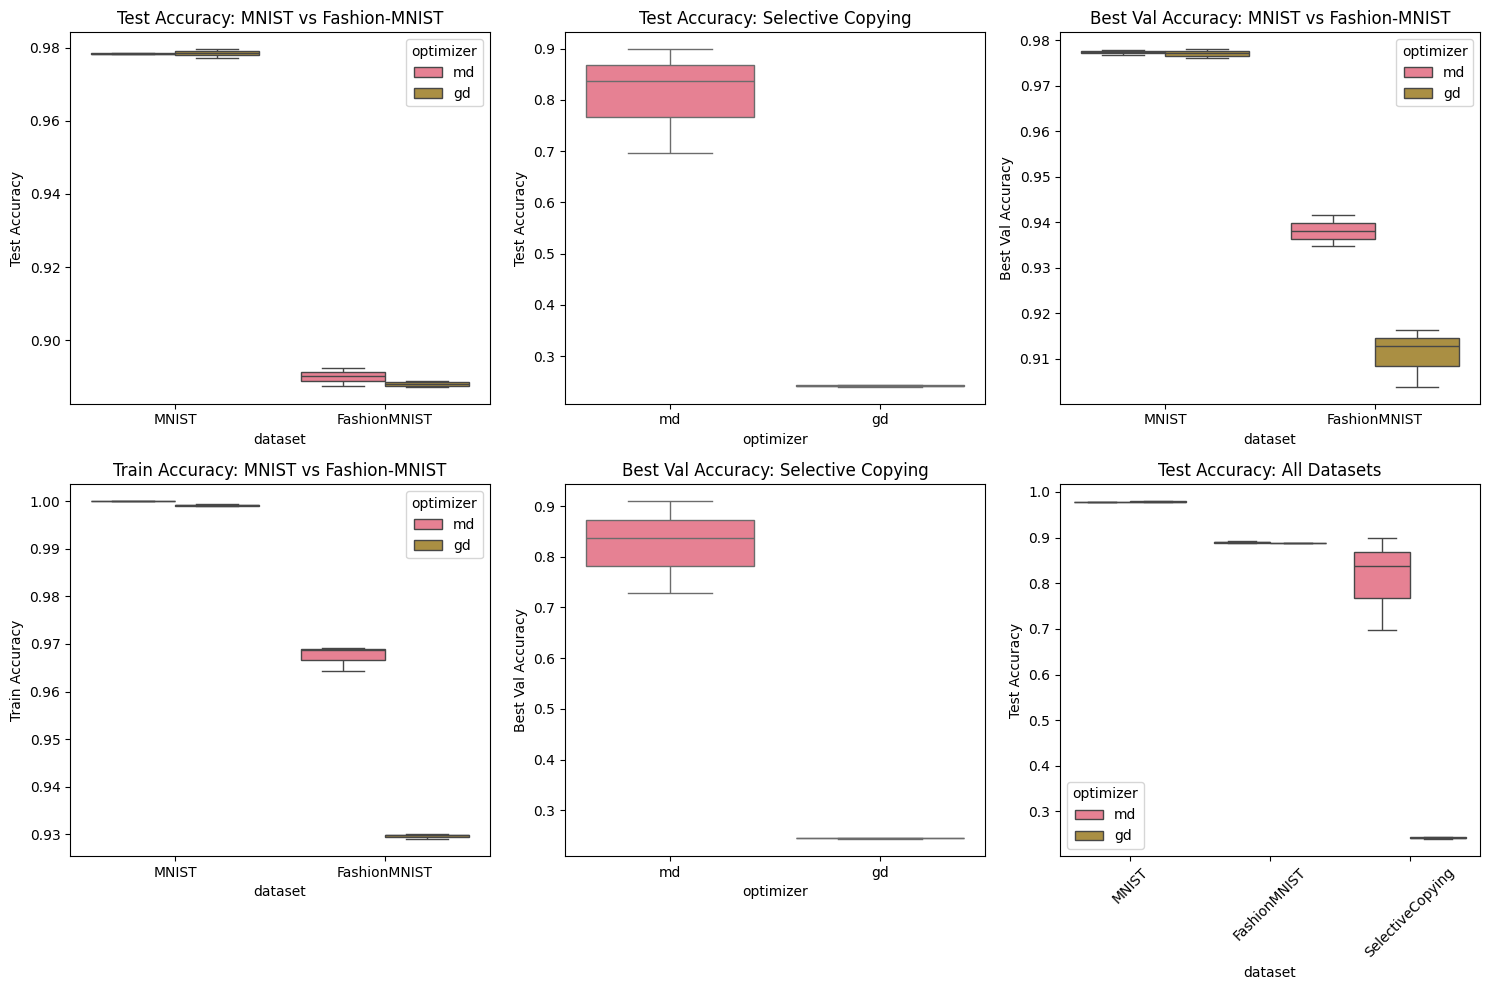

In [30]:
plot_comparison(mnist_clean, selective_clean)

In [31]:
def plot_comparison_better(mnist_df, selective_df):
    """Create cleaner comparison plots with relative performance"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Relative performance (MD - GD) for each dataset
    datasets_data = []
    
    # MNIST data
    if len(mnist_df) > 0 and 'test/acc' in mnist_df.columns:
        for dataset in ['MNIST', 'FashionMNIST']:
            data = mnist_df[mnist_df['dataset'] == dataset]
            if len(data) > 0:
                md_acc = data[data['optimizer'] == 'md']['test/acc'].mean()
                gd_acc = data[data['optimizer'] == 'gd']['test/acc'].mean()
                if pd.notna(md_acc) and pd.notna(gd_acc):
                    datasets_data.append({
                        'dataset': dataset,
                        'md_advantage': (md_acc - gd_acc) * 100,  # Convert to percentage points
                        'md_acc': md_acc,
                        'gd_acc': gd_acc
                    })
    
    # Selective Copying data
    if len(selective_df) > 0 and 'test/acc' in selective_df.columns:
        md_acc = selective_df[selective_df['optimizer'] == 'md']['test/acc'].mean()
        gd_acc = selective_df[selective_df['optimizer'] == 'gd']['test/acc'].mean()
        if pd.notna(md_acc) and pd.notna(gd_acc):
            datasets_data.append({
                'dataset': 'SelectiveCopying',
                'md_advantage': (md_acc - gd_acc) * 100,
                'md_acc': md_acc,
                'gd_acc': gd_acc
            })
    
    if datasets_data:
        df_plot = pd.DataFrame(datasets_data)
        bars = axes[0,0].bar(df_plot['dataset'], df_plot['md_advantage'], 
                            color=['green' if x > 0 else 'red' for x in df_plot['md_advantage']])
        axes[0,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[0,0].set_title('MD Advantage over GD\n(percentage points)')
        axes[0,0].set_ylabel('MD - GD (% points)')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, val in zip(bars, df_plot['md_advantage']):
            axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1 if val > 0 else val - 0.3,
                          f'{val:.2f}', ha='center', va='bottom' if val > 0 else 'top')
    
    # Plot 2: Side-by-side accuracy comparison
    if datasets_data:
        x = range(len(df_plot))
        width = 0.35
        axes[0,1].bar([i - width/2 for i in x], df_plot['md_acc'], width, label='MD', alpha=0.8)
        axes[0,1].bar([i + width/2 for i in x], df_plot['gd_acc'], width, label='GD', alpha=0.8)
        axes[0,1].set_title('Test Accuracy Comparison')
        axes[0,1].set_ylabel('Test Accuracy')
        axes[0,1].set_xticks(x)
        axes[0,1].set_xticklabels(df_plot['dataset'], rotation=45)
        axes[0,1].legend()
    
    # Plot 3: Individual run scatter plot for MNIST/Fashion
    if len(mnist_df) > 0 and 'test/acc' in mnist_df.columns:
        for i, dataset in enumerate(['MNIST', 'FashionMNIST']):
            data = mnist_df[mnist_df['dataset'] == dataset]
            md_data = data[data['optimizer'] == 'md']['test/acc']
            gd_data = data[data['optimizer'] == 'gd']['test/acc']
            
            axes[1,0].scatter([i-0.1]*len(md_data), md_data, alpha=0.7, label='MD' if i==0 else "", s=60)
            axes[1,0].scatter([i+0.1]*len(gd_data), gd_data, alpha=0.7, label='GD' if i==0 else "", s=60)
        
        axes[1,0].set_title('Individual Runs: MNIST & Fashion-MNIST')
        axes[1,0].set_ylabel('Test Accuracy')
        axes[1,0].set_xticks([0, 1])
        axes[1,0].set_xticklabels(['MNIST', 'Fashion-MNIST'])
        axes[1,0].legend()
    
    # Plot 4: Validation vs Test accuracy
    combined_data = []
    for df, project in [(mnist_df, 'MNIST'), (selective_df, 'Selective')]:
        if len(df) > 0 and 'test/acc' in df.columns and 'val/acc_best' in df.columns:
            for _, row in df.iterrows():
                if pd.notna(row['test/acc']) and pd.notna(row['val/acc_best']):
                    combined_data.append({
                        'test_acc': row['test/acc'],
                        'val_acc': row['val/acc_best'],
                        'optimizer': row['optimizer'],
                        'project': project
                    })
    
    if combined_data:
        combined_df = pd.DataFrame(combined_data)
        for opt, marker in [('md', 'o'), ('gd', 's')]:
            data = combined_df[combined_df['optimizer'] == opt]
            axes[1,1].scatter(data['val_acc'], data['test_acc'], 
                             alpha=0.7, label=opt.upper(), marker=marker, s=60)
        
        # Add diagonal line
        min_acc = min(combined_df['val_acc'].min(), combined_df['test_acc'].min())
        max_acc = max(combined_df['val_acc'].max(), combined_df['test_acc'].max())
        axes[1,1].plot([min_acc, max_acc], [min_acc, max_acc], 'k--', alpha=0.3)
        
        axes[1,1].set_title('Validation vs Test Accuracy')
        axes[1,1].set_xlabel('Best Val Accuracy')
        axes[1,1].set_ylabel('Test Accuracy')
        axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

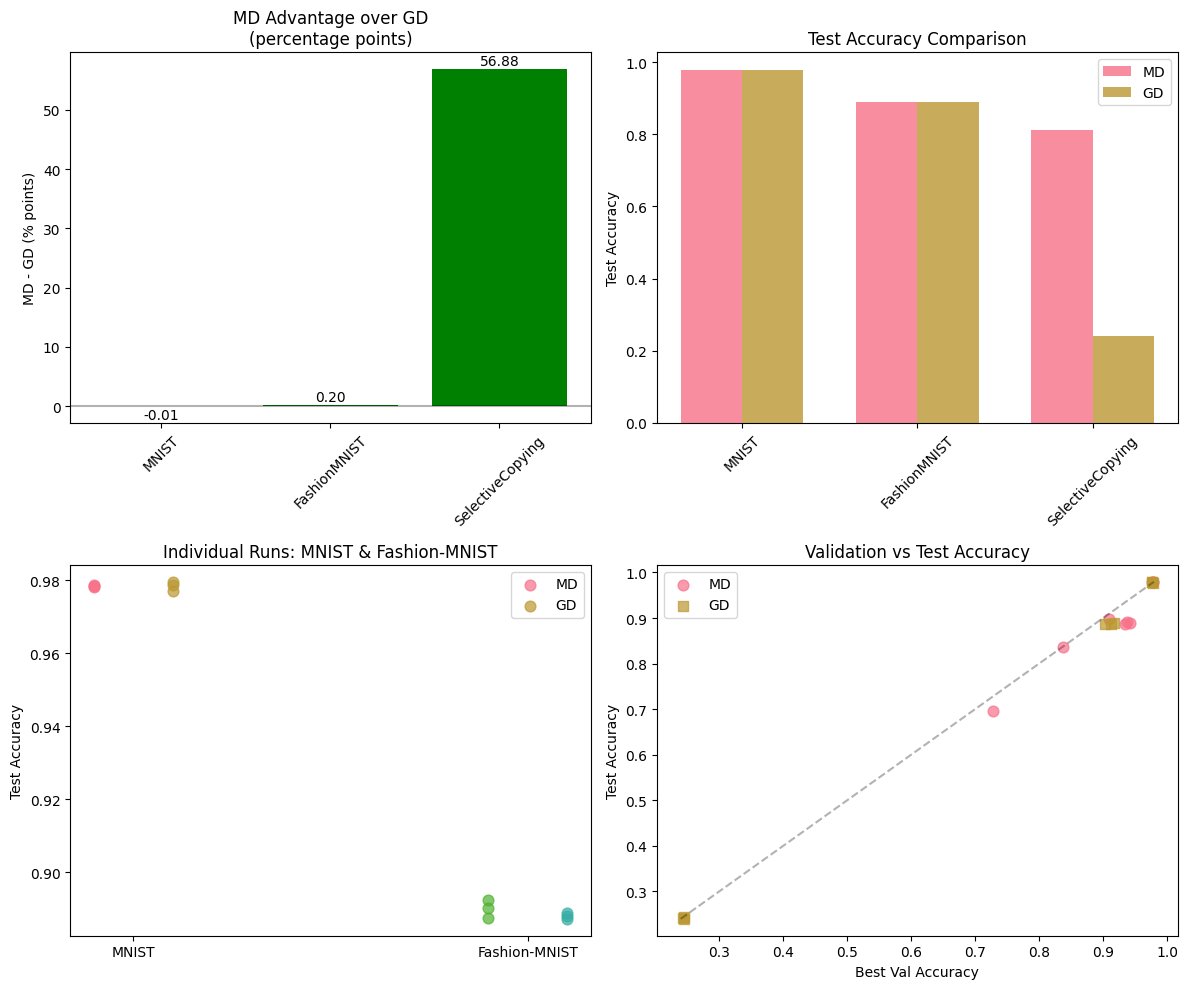

In [32]:
plot_comparison_better(mnist_clean, selective_clean)

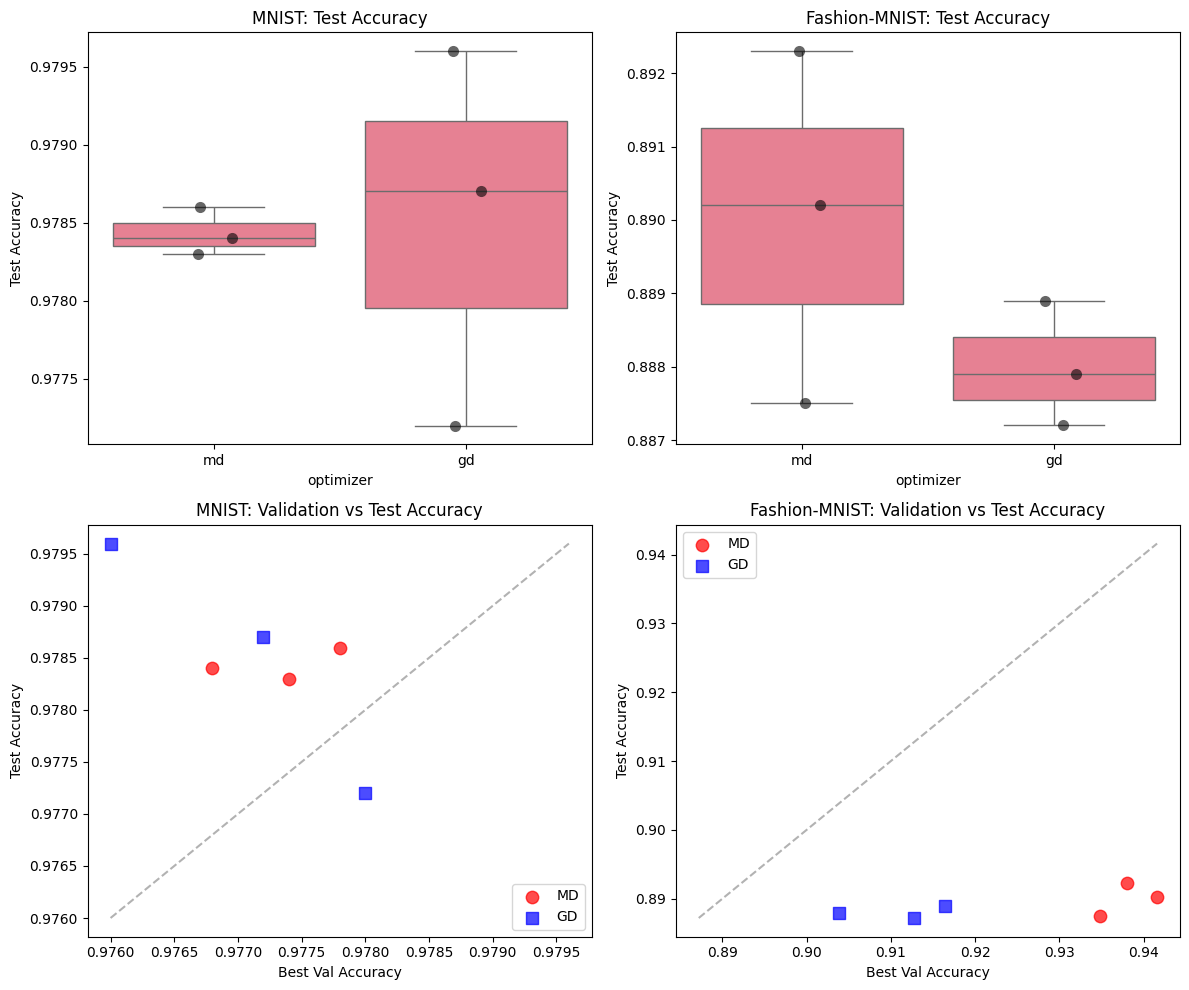

MNIST & Fashion-MNIST Analysis

📊 MNIST Results:
------------------------------

test/acc:
  MD: 0.9784 ± 0.0002 (n=3)
  GD: 0.9785 ± 0.0012 (n=3)
  Difference (MD-GD): -0.0001 (p=0.9293)

val/acc_best:
  MD: 0.9773 ± 0.0005 (n=3)
  GD: 0.9771 ± 0.0010 (n=3)
  Difference (MD-GD): 0.0003 (p=0.7025)

train/acc:
  MD: 1.0000 ± 0.0000 (n=3)
  GD: 0.9992 ± 0.0001 (n=3)
  Difference (MD-GD): 0.0008 (p=0.0006)
  🏆 MD significantly better!

📊 FashionMNIST Results:
------------------------------

test/acc:
  MD: 0.8900 ± 0.0024 (n=3)
  GD: 0.8880 ± 0.0009 (n=3)
  Difference (MD-GD): 0.0020 (p=0.2464)

val/acc_best:
  MD: 0.9381 ± 0.0034 (n=3)
  GD: 0.9110 ± 0.0065 (n=3)
  Difference (MD-GD): 0.0271 (p=0.0030)
  🏆 MD significantly better!

train/acc:
  MD: 0.9674 ± 0.0026 (n=3)
  GD: 0.9296 ± 0.0005 (n=3)
  Difference (MD-GD): 0.0378 (p=0.0000)
  🏆 MD significantly better!


In [33]:
def plot_mnist_analysis(mnist_df):
    """Analyze MNIST and Fashion-MNIST results separately"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Filter data for each dataset
    mnist_data = mnist_df[mnist_df['dataset'] == 'MNIST']
    fashion_data = mnist_df[mnist_df['dataset'] == 'FashionMNIST']
    
    # Plot 1: MNIST results
    if len(mnist_data) > 0 and 'test/acc' in mnist_data.columns:
        sns.boxplot(data=mnist_data, x='optimizer', y='test/acc', ax=axes[0,0])
        axes[0,0].set_title('MNIST: Test Accuracy')
        axes[0,0].set_ylabel('Test Accuracy')
        
        # Add individual points
        sns.stripplot(data=mnist_data, x='optimizer', y='test/acc', 
                     ax=axes[0,0], color='black', alpha=0.6, size=8)
    
    # Plot 2: Fashion-MNIST results  
    if len(fashion_data) > 0 and 'test/acc' in fashion_data.columns:
        sns.boxplot(data=fashion_data, x='optimizer', y='test/acc', ax=axes[0,1])
        axes[0,1].set_title('Fashion-MNIST: Test Accuracy')
        axes[0,1].set_ylabel('Test Accuracy')
        
        # Add individual points
        sns.stripplot(data=fashion_data, x='optimizer', y='test/acc', 
                     ax=axes[0,1], color='black', alpha=0.6, size=8)
    
    # Plot 3: MNIST validation vs test
    if len(mnist_data) > 0 and 'test/acc' in mnist_data.columns and 'val/acc_best' in mnist_data.columns:
        for opt, marker, color in [('md', 'o', 'red'), ('gd', 's', 'blue')]:
            data = mnist_data[mnist_data['optimizer'] == opt]
            axes[1,0].scatter(data['val/acc_best'], data['test/acc'], 
                             alpha=0.7, label=opt.upper(), marker=marker, s=80, color=color)
        
        axes[1,0].set_title('MNIST: Validation vs Test Accuracy')
        axes[1,0].set_xlabel('Best Val Accuracy')
        axes[1,0].set_ylabel('Test Accuracy')
        axes[1,0].legend()
        
        # Add diagonal line
        min_acc = min(mnist_data['val/acc_best'].min(), mnist_data['test/acc'].min())
        max_acc = max(mnist_data['val/acc_best'].max(), mnist_data['test/acc'].max())
        axes[1,0].plot([min_acc, max_acc], [min_acc, max_acc], 'k--', alpha=0.3)
    
    # Plot 4: Fashion-MNIST validation vs test
    if len(fashion_data) > 0 and 'test/acc' in fashion_data.columns and 'val/acc_best' in fashion_data.columns:
        for opt, marker, color in [('md', 'o', 'red'), ('gd', 's', 'blue')]:
            data = fashion_data[fashion_data['optimizer'] == opt]
            axes[1,1].scatter(data['val/acc_best'], data['test/acc'], 
                             alpha=0.7, label=opt.upper(), marker=marker, s=80, color=color)
        
        axes[1,1].set_title('Fashion-MNIST: Validation vs Test Accuracy')
        axes[1,1].set_xlabel('Best Val Accuracy')
        axes[1,1].set_ylabel('Test Accuracy')
        axes[1,1].legend()
        
        # Add diagonal line
        min_acc = min(fashion_data['val/acc_best'].min(), fashion_data['test/acc'].min())
        max_acc = max(fashion_data['val/acc_best'].max(), fashion_data['test/acc'].max())
        axes[1,1].plot([min_acc, max_acc], [min_acc, max_acc], 'k--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_mnist_stats(mnist_df):
    """Print detailed statistics for MNIST/Fashion-MNIST"""
    print("="*60)
    print("MNIST & Fashion-MNIST Analysis")
    print("="*60)
    
    for dataset in ['MNIST', 'FashionMNIST']:
        data = mnist_df[mnist_df['dataset'] == dataset]
        if len(data) == 0:
            continue
            
        print(f"\n📊 {dataset} Results:")
        print("-" * 30)
        
        for metric in ['test/acc', 'val/acc_best', 'train/acc']:
            if metric in data.columns:
                print(f"\n{metric}:")
                for opt in ['md', 'gd']:
                    opt_data = data[data['optimizer'] == opt][metric].dropna()
                    if len(opt_data) > 0:
                        print(f"  {opt.upper()}: {opt_data.mean():.4f} ± {opt_data.std():.4f} (n={len(opt_data)})")
                
                # Statistical comparison
                md_data = data[data['optimizer'] == 'md'][metric].dropna()
                gd_data = data[data['optimizer'] == 'gd'][metric].dropna()
                
                if len(md_data) > 0 and len(gd_data) > 0:
                    from scipy import stats
                    t_stat, p_value = stats.ttest_ind(md_data, gd_data)
                    diff = md_data.mean() - gd_data.mean()
                    print(f"  Difference (MD-GD): {diff:.4f} (p={p_value:.4f})")
                    if p_value < 0.05:
                        winner = "MD" if diff > 0 else "GD"
                        print(f"  🏆 {winner} significantly better!")

# Usage:
plot_mnist_analysis(mnist_clean)
print_mnist_stats(mnist_clean)

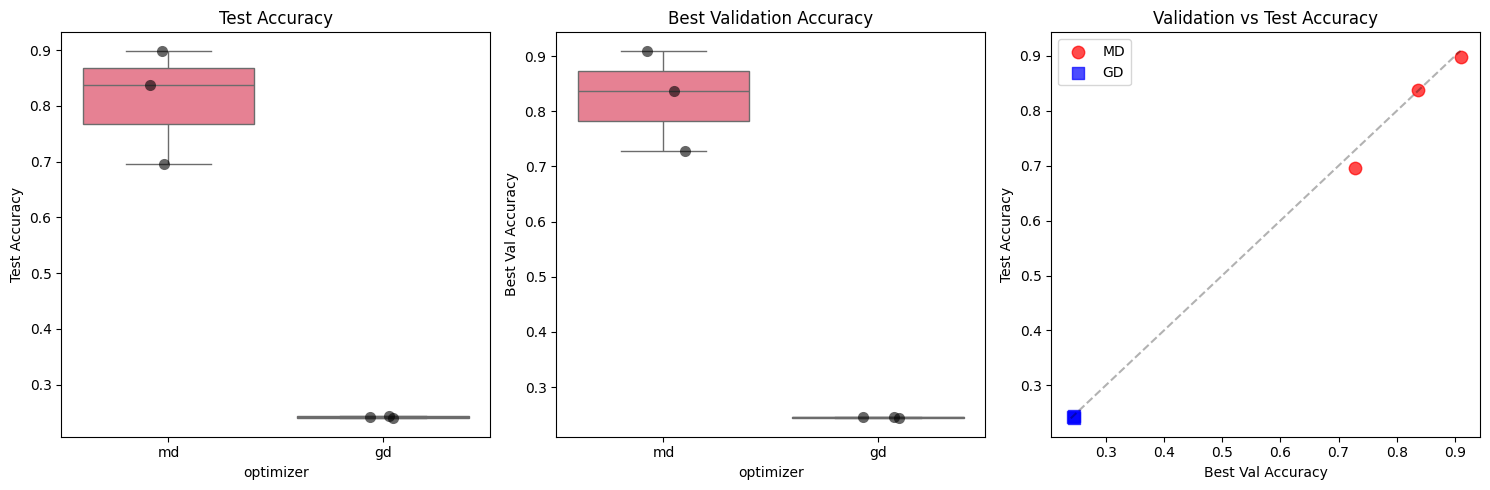

Selective Copying Analysis

test/acc:
  MD: 0.8109 ± 0.1037 (n=3)
  GD: 0.2421 ± 0.0023 (n=3)
  Difference (MD-GD): 0.5688 (p=0.0007)

val/acc_best:
  MD: 0.8251 ± 0.0911 (n=3)
  GD: 0.2448 ± 0.0012 (n=3)
  Difference (MD-GD): 0.5803 (p=0.0004)

train/acc_epoch:
  MD: 0.8180 ± 0.0921 (n=3)
  GD: 0.2408 ± 0.0005 (n=3)
  Difference (MD-GD): 0.5772 (p=0.0004)


In [34]:
def plot_selective_analysis(selective_df):
    """Analyze Selective Copying results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Test accuracy comparison
    if len(selective_df) > 0 and 'test/acc' in selective_df.columns:
        sns.boxplot(data=selective_df, x='optimizer', y='test/acc', ax=axes[0])
        sns.stripplot(data=selective_df, x='optimizer', y='test/acc', 
                     ax=axes[0], color='black', alpha=0.6, size=8)
        axes[0].set_title('Test Accuracy')
        axes[0].set_ylabel('Test Accuracy')
    
    # Plot 2: Validation accuracy comparison
    if len(selective_df) > 0 and 'val/acc_best' in selective_df.columns:
        sns.boxplot(data=selective_df, x='optimizer', y='val/acc_best', ax=axes[1])
        sns.stripplot(data=selective_df, x='optimizer', y='val/acc_best', 
                     ax=axes[1], color='black', alpha=0.6, size=8)
        axes[1].set_title('Best Validation Accuracy')
        axes[1].set_ylabel('Best Val Accuracy')
    
    # Plot 3: Validation vs test accuracy
    if len(selective_df) > 0 and 'test/acc' in selective_df.columns and 'val/acc_best' in selective_df.columns:
        for opt, marker, color in [('md', 'o', 'red'), ('gd', 's', 'blue')]:
            data = selective_df[selective_df['optimizer'] == opt]
            axes[2].scatter(data['val/acc_best'], data['test/acc'], 
                           alpha=0.7, label=opt.upper(), marker=marker, s=80, color=color)
        
        axes[2].set_title('Validation vs Test Accuracy')
        axes[2].set_xlabel('Best Val Accuracy')
        axes[2].set_ylabel('Test Accuracy')
        axes[2].legend()
        
        # Add diagonal line
        min_acc = min(selective_df['val/acc_best'].min(), selective_df['test/acc'].min())
        max_acc = max(selective_df['val/acc_best'].max(), selective_df['test/acc'].max())
        axes[2].plot([min_acc, max_acc], [min_acc, max_acc], 'k--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_selective_stats(selective_df):
    """Print statistics for Selective Copying"""
    print("="*40)
    print("Selective Copying Analysis")
    print("="*40)
    
    for metric in ['test/acc', 'val/acc_best', 'train/acc_epoch']:
        if metric in selective_df.columns:
            print(f"\n{metric}:")
            for opt in ['md', 'gd']:
                opt_data = selective_df[selective_df['optimizer'] == opt][metric].dropna()
                if len(opt_data) > 0:
                    print(f"  {opt.upper()}: {opt_data.mean():.4f} ± {opt_data.std():.4f} (n={len(opt_data)})")
            
            # Statistical comparison
            md_data = selective_df[selective_df['optimizer'] == 'md'][metric].dropna()
            gd_data = selective_df[selective_df['optimizer'] == 'gd'][metric].dropna()
            
            if len(md_data) > 0 and len(gd_data) > 0:
                from scipy import stats
                t_stat, p_value = stats.ttest_ind(md_data, gd_data)
                diff = md_data.mean() - gd_data.mean()
                print(f"  Difference (MD-GD): {diff:.4f} (p={p_value:.4f})")

# Usage:
plot_selective_analysis(selective_clean)
print_selective_stats(selective_clean)